# Age, Gender, and Expression Recognition

## Notebook Imports

In [1]:
import os
import pathlib
import sklearn
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
torch.__version__

/tmp/ipykernel_23/3251992049.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2.4.0'

## Data Loading & Data Preprocessing

In [2]:
EMOTION_IMAGE_PATH = Path("/kaggle/input/emotion-detection-fer")

EMOTION_TRAIN_PATH = EMOTION_IMAGE_PATH / "train"
EMOTION_TEST_PATH = EMOTION_IMAGE_PATH / "test"

TRAIN_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TRAIN_PATH.glob('*/*.png'))
TEST_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TEST_PATH.glob('*/*.png'))

AGEUTK = Path("/kaggle/input/ageutk")
AGEUTK_PATH_LIST = list((AGEUTK / 'UTKFace').glob("*/*/*.jpg.chip.jpg"))

In [3]:
def parse_filename(filename):
    parts = filename.split("_")
    return {"path": f"/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/{filename}", "age": int(parts[0]), "gender": int(parts[1])}

In [4]:
age_bins = [i for i in range(0, 91, 5)]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

ageutkface_data = [parse_filename(path.name) for path in AGEUTK_PATH_LIST]
ageutkface_metadata = pd.DataFrame(ageutkface_data)

In [5]:
ageutkface_metadata.loc[ageutkface_metadata['age'] > 90, 'age'] = 90

In [6]:
ageutkface_metadata['age'] = pd.cut(
    ageutkface_metadata['age'], bins=age_bins, labels=age_labels, right=False
)
ageutkface_metadata.head()

path    age  gender
0  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  25-29       0
1  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  20-24       1
2  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  20-24       1
3  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  25-29       0
4  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...  15-19       1

In [7]:
ageutkface_metadata[ageutkface_metadata['age'].isna()]

path  age  gender
27     /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       0
118    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       1
122    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...  NaN       1
359    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       0
550    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       1
...                                                  ...  ...     ...
21853  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       1
21998  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...  NaN       1
23565  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       0
23602  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/9...  NaN       1
23620  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/1...  NaN       1

[169 rows x 3 columns]

In [8]:
ageutkface_metadata = ageutkface_metadata.dropna(subset=['age']).reset_index(drop=True)

In [9]:
ageutkface_metadata[ageutkface_metadata['age'].isna()]

Empty DataFrame
Columns: [path, age, gender]
Index: []

In [10]:
train_ageutk, test_ageutk = train_test_split(ageutkface_metadata, shuffle=True, test_size=0.2)
train_ageutk.shape, test_ageutk.shape

((18830, 3), (4708, 3))

In [11]:
train_ageutk.head()

path    age  gender
3122   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/7...  70-74       0
3377   /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...  30-34       1
517    /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/6...  65-69       0
20395  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/3...    0-4       0
15341  /kaggle/input/ageutk/UTKFace/UTKFace/UTKFace/2...  25-29       1

In [12]:
train_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TRAIN_EMOTION_IMAGE_PATH_LIST]
test_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TEST_EMOTION_IMAGE_PATH_LIST]

train_emotion= pd.DataFrame(train_emotion_data)
test_emotion= pd.DataFrame(test_emotion_data)

train_emotion.head()

path  emotion
0  /kaggle/input/emotion-detection-fer/train/fear...  fearful
1  /kaggle/input/emotion-detection-fer/train/fear...  fearful
2  /kaggle/input/emotion-detection-fer/train/fear...  fearful
3  /kaggle/input/emotion-detection-fer/train/fear...  fearful
4  /kaggle/input/emotion-detection-fer/train/fear...  fearful

In [13]:
ageutkface_metadata.columns, train_emotion.columns

(Index(['path', 'age', 'gender'], dtype='object'),
 Index(['path', 'emotion'], dtype='object'))

## Data Transformation

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None, emotion=True):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            if emotion:
                f = f.convert('RGB')
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=14)

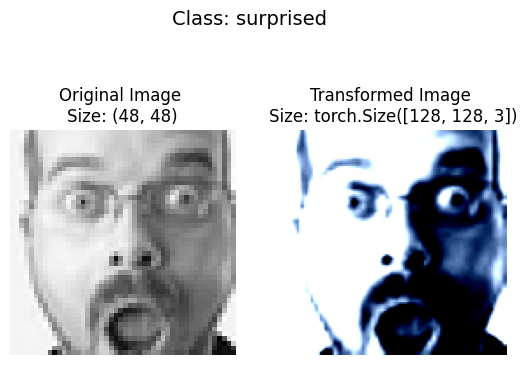

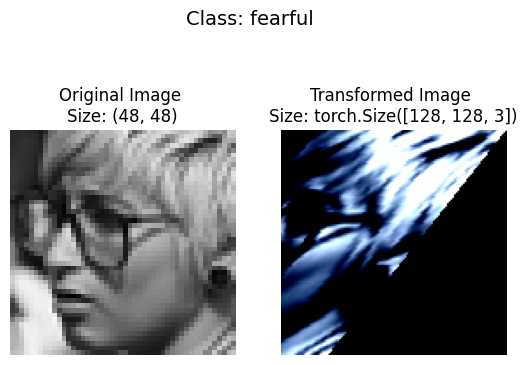

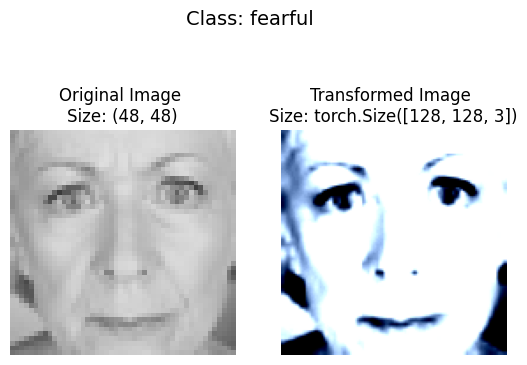

In [16]:
plot_transformed_images(image_paths=TRAIN_EMOTION_IMAGE_PATH_LIST,
                        transform=train_transform,
                        n=3,
                        seed=42)

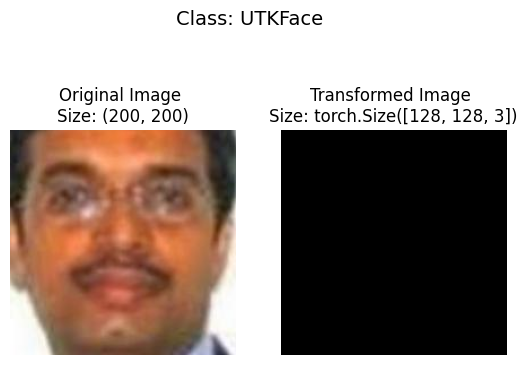

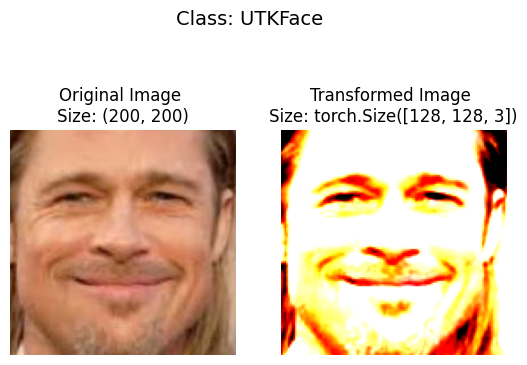

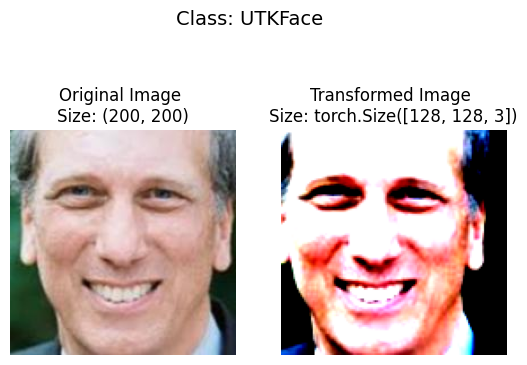

In [17]:
plot_transformed_images(image_paths=AGEUTK_PATH_LIST,
                        transform=train_transform,
                        n=3, emotion=False,
                        seed=42)

## Combining Emotion and UTKFace Datasets

Creating a custom PyTorch Dataset class to integrate the datasets for emotion, age, and gender

In [18]:
emotion_idx = {
    'angry': 0,
    'disgusted': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}

age_idx = {label:i for i, label in enumerate(age_labels)}
age_idx['nan'] = None

In [19]:
class CombinedCustomDataset(Dataset):
    def __init__(self, emotion_metadata, ageutkface_metadata, emotion_idx:dict, age_idx:dict, transform=None):
        self.ageutk_df = ageutkface_metadata
        self.emotion_df = emotion_metadata
        self.transform = transform
        self.emotion_idx = emotion_idx
        self.age_idx = age_idx

    def __len__(self):
        return len(self.ageutk_df) + len(self.emotion_df)

    def __getitem__(self, idx):
        if idx < len(self.ageutk_df):  # AGE-UTK sample
            row = self.ageutk_df.iloc[idx]
            image = Image.open(row['path'])
            label = [
                self.age_idx[row['age']],
                row['gender'],
                -1
            ]
        else:  # Emotion sample
            row = self.emotion_df.iloc[idx - len(self.ageutk_df)]
            image = Image.open(row['path']).convert('RGB')
            label = [
                -1, 
                -1,
                self.emotion_idx[row['emotion']]
            ]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

In [20]:
train_combined_dataset = CombinedCustomDataset(emotion_metadata=train_emotion, ageutkface_metadata=train_ageutk, 
                                               transform=train_transform, emotion_idx=emotion_idx, age_idx=age_idx)
test_combined_dataset = CombinedCustomDataset(emotion_metadata=test_emotion, ageutkface_metadata=test_ageutk, 
                                              transform=test_transform, emotion_idx=emotion_idx, age_idx=age_idx)


train_combined_dataloader = DataLoader(train_combined_dataset, batch_size=16, 
                                       shuffle=True, num_workers=os.cpu_count())
test_combined_dataloader = DataLoader(test_combined_dataset, batch_size=16, 
                                      shuffle=True, num_workers=os.cpu_count())

In [21]:
train_images, train_labels = next(iter(train_combined_dataloader))
train_images.shape, train_labels.shape, train_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3]),
 tensor([[-1, -1,  3],
         [-1, -1,  4],
         [-1, -1,  6],
         [-1, -1,  5],
         [-1, -1,  6]]))

In [22]:
test_images, test_labels = next(iter(test_combined_dataloader))
test_images.shape, test_labels.shape, test_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3]),
 tensor([[-1, -1,  6],
         [-1, -1,  0],
         [-1, -1,  5],
         [ 5,  1, -1],
         [11,  0, -1]]))

In [23]:
# Visualize images with their labels
def visualize_batch(images, labels):
    """
    Visualizes a batch of images in an 4x4 grid.
    
    Parameters:
        images (torch.Tensor): Batch of images (B, C, H, W).
        labels (list): Corresponding labels [[age_idx, gender_idx, emotion_idx], ...].
    """
    # Define the grid size
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue
        
        image = images[i]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f"Age Id: {labels[i][0]}\nGender Id: {labels[i][1]}\nEmotion Id: {labels[i][2]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

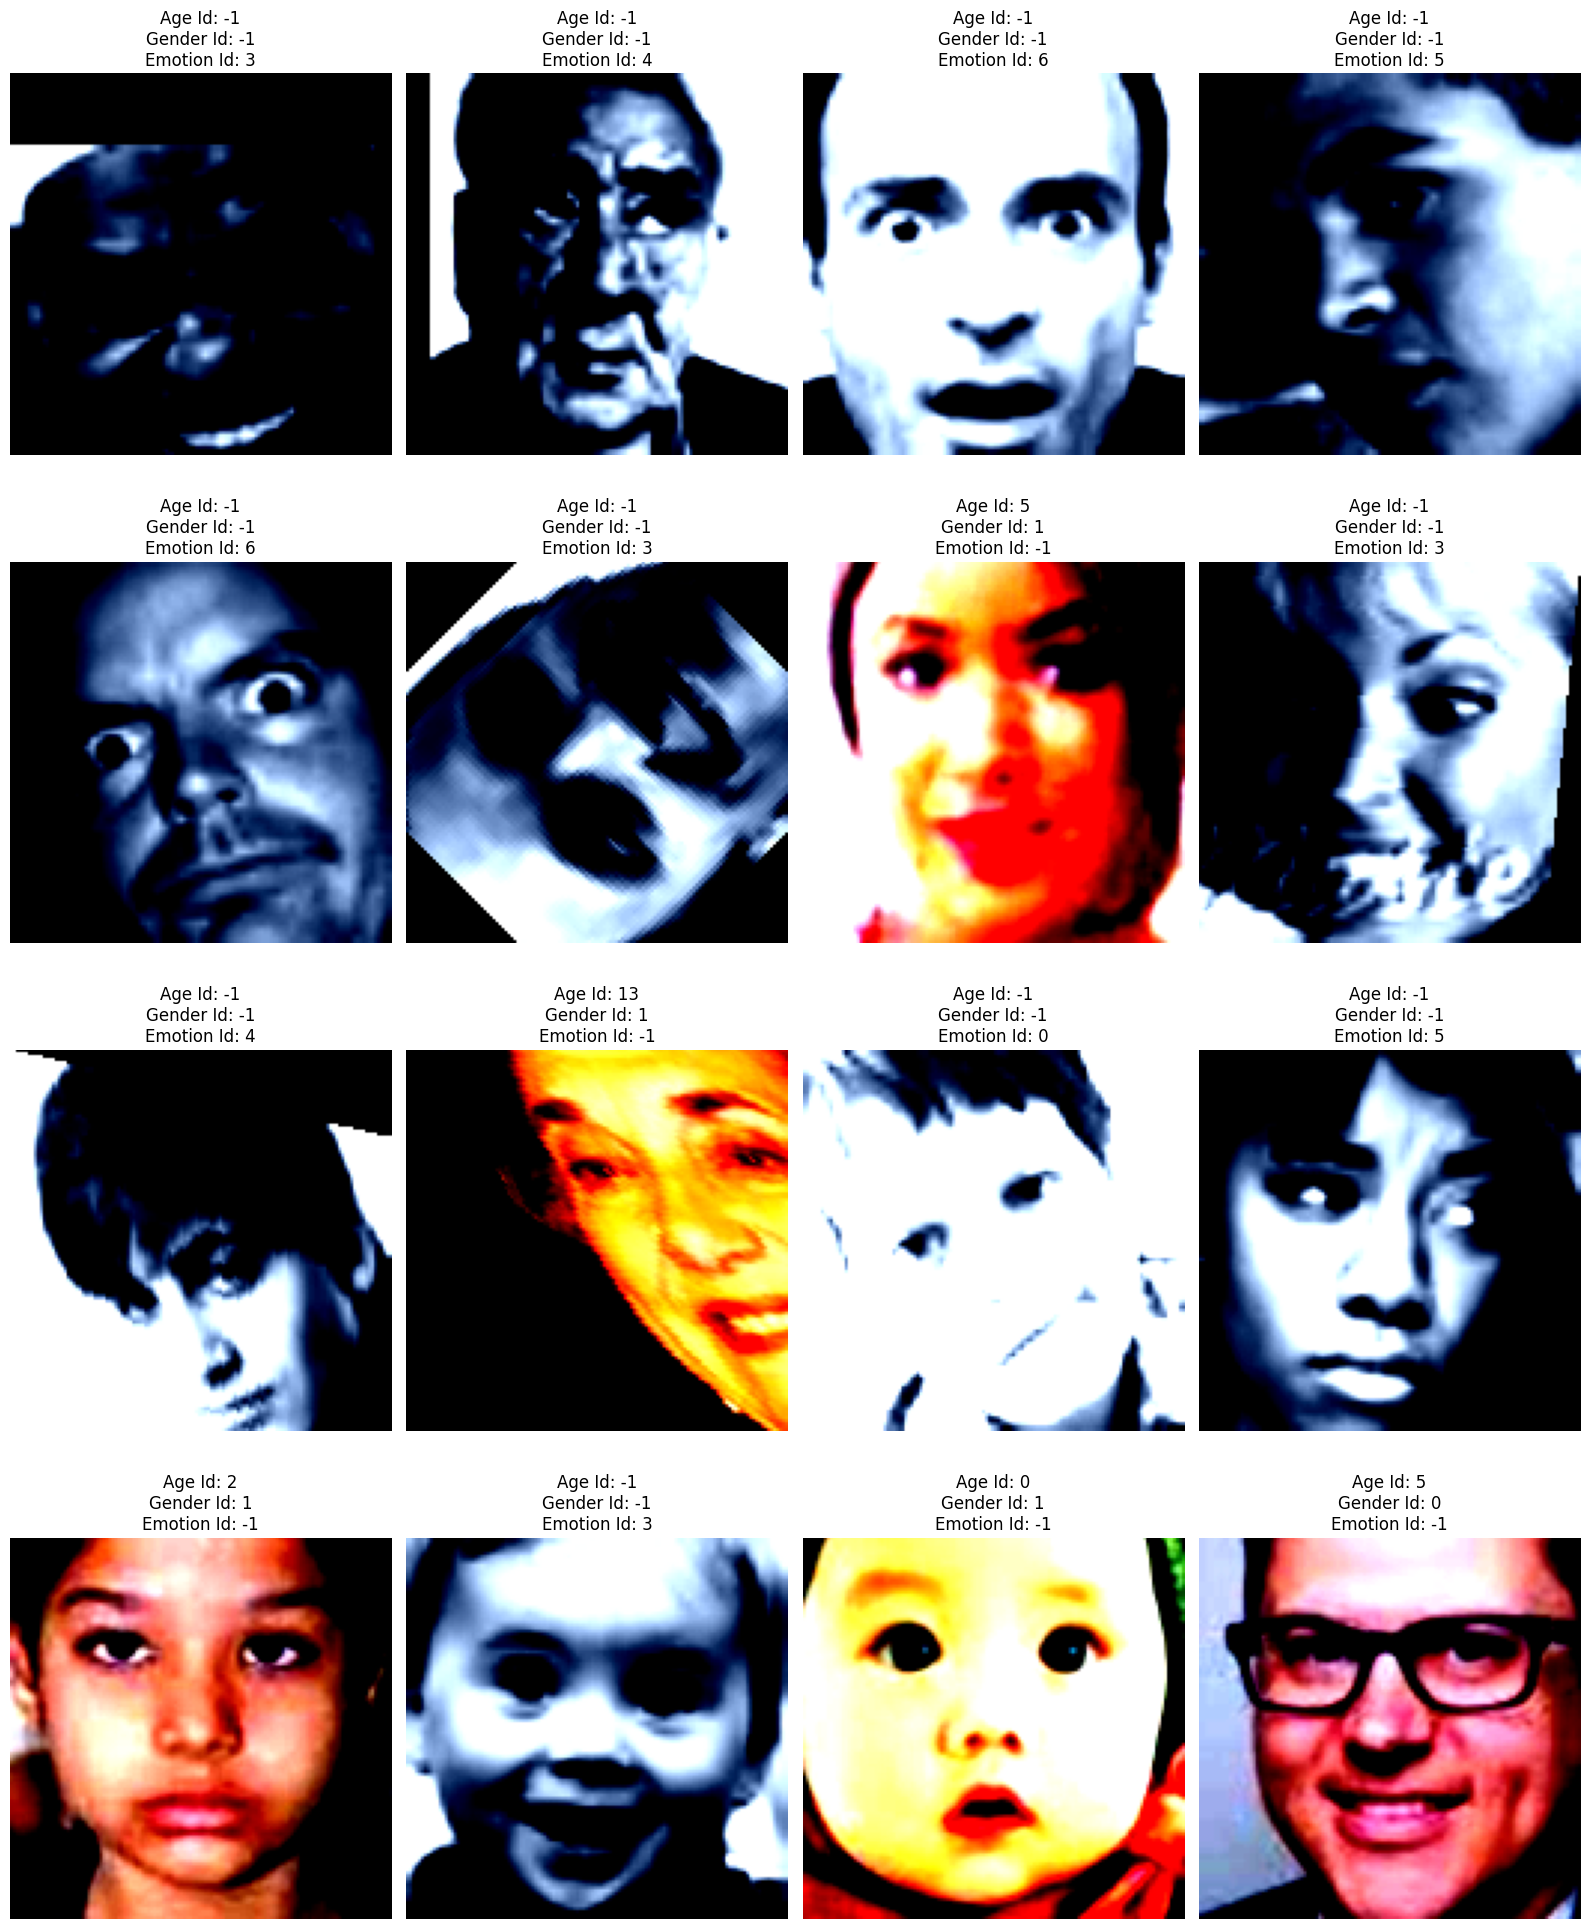

In [24]:
visualize_batch(train_images, train_labels)

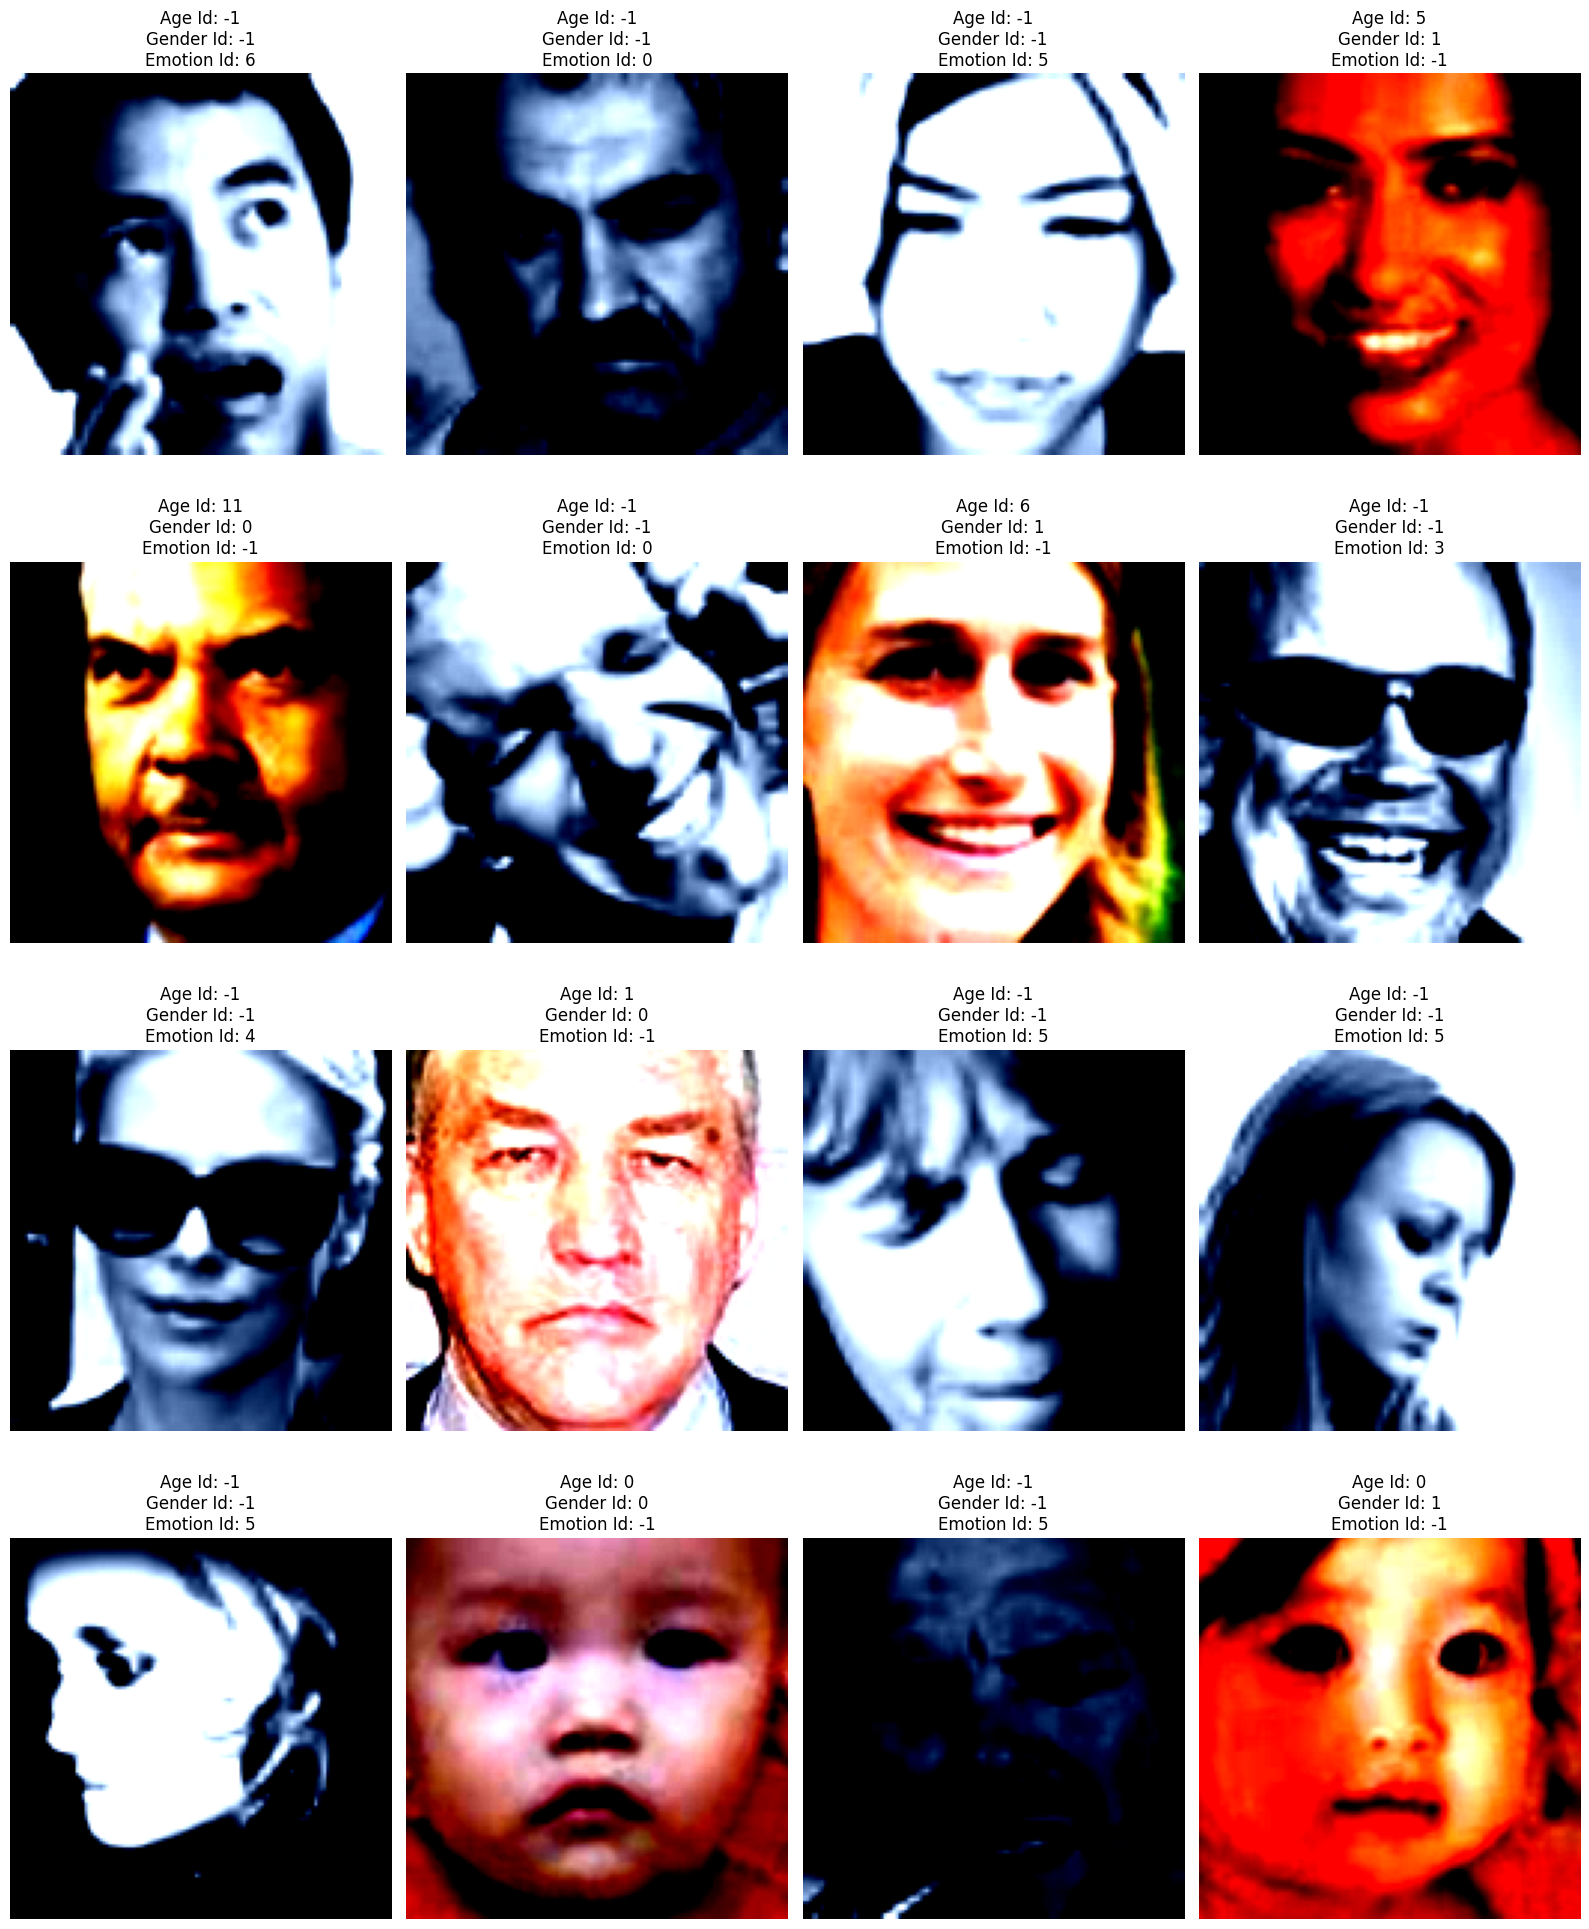

In [25]:
visualize_batch(test_images, test_labels)

## Model Training & Evaluation

### Model Architecture

In [26]:
class CustomMultiHeadModel(nn.Module):
    def __init__(self, num_age_bins:int, num_genders:int, 
                 hidden_units:int, num_emotions:int) -> None:
        super().__init__()
        
        backbone = models.resnet18(pretrained=True)
        self.shared_backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove classification head
        self.age_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.fc.in_features, num_age_bins)
        )
        self.gender_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.fc.in_features, 2)
        )
        self.emotion_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.fc.in_features, num_emotions)
        )

    def forward(self, x):
        features = self.shared_backbone(x)
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        emotion_logits = self.emotion_head(features)
        return age_logits, gender_logits, emotion_logits
        

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model Training
* `train_step()` -- takes a model and dataloader and trains the model on the `DataLoader`
* `test_step()` -- takes a model and dataloader and evaluates the model on the `DataLoader`

In [28]:
def train_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, optimizer, device):
    """
    Perform a single training step for one epoch.

    Parameters:
        model: PyTorch multi-head model.
        dataloader: DataLoader for training data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        optimizer: Optimizer to update the model parameters.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        train_loss: Average loss over the epoch.
        train_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """
    model.train()
    train_loss = 0
    total_age_accuracy, total_gender_accuracy, total_emotion_accuracy = 0, 0, 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward Pass
        age_pred, gender_pred, emotion_pred = model(X)

        # Initialize accumulators
        num_tasks = 0
        batch_loss = 0

        # Calculate and mask Age Loss
        valid_age_indices = y[:, 0] != -1
        if valid_age_indices.sum() > 0:
            age_loss = age_loss_fn(age_pred[valid_age_indices], y[valid_age_indices, 0].long())
            batch_loss += age_loss
            num_tasks += 1

            # Age Accuracy
            age_pred_class = age_pred.argmax(dim=1)
            age_accuracy = (age_pred_class[valid_age_indices] == y[valid_age_indices, 0]).sum().item() / valid_age_indices.sum().item()
            total_age_accuracy += age_accuracy

        # Calculate and mask Gender Loss
        valid_gender_indices = y[:, 1] != -1
        if valid_gender_indices.sum() > 0:
            gender_loss = gender_loss_fn(gender_pred[valid_gender_indices], y[valid_gender_indices, 1].long())
            batch_loss += gender_loss
            num_tasks += 1

            # Gender Accuracy
            gender_pred_class = gender_pred.argmax(dim=1)
            gender_accuracy = (gender_pred_class[valid_gender_indices] == y[valid_gender_indices, 1]).sum().item() / valid_gender_indices.sum().item()
            total_gender_accuracy += gender_accuracy

        # Calculate and mask Emotion Loss
        valid_emotion_indices = y[:, 2] != -1
        if valid_emotion_indices.sum() > 0:
            emotion_loss = emotion_loss_fn(emotion_pred[valid_emotion_indices], y[valid_emotion_indices, 2].long())
            batch_loss += emotion_loss
            num_tasks += 1

            # Emotion Accuracy
            emotion_pred_class = emotion_pred.argmax(dim=1)
            emotion_accuracy = (emotion_pred_class[valid_emotion_indices] == y[valid_emotion_indices, 2]).sum().item() / valid_emotion_indices.sum().item()
            total_emotion_accuracy += emotion_accuracy

        # Backpropagation
        optimizer.zero_grad()
        if num_tasks > 0:  # Avoid division by zero
            batch_loss = batch_loss / num_tasks
            train_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

    # Average Loss and Accuracy
    train_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches
    avg_gender_accuracy = total_gender_accuracy / num_batches
    avg_emotion_accuracy = total_emotion_accuracy / num_batches
    train_acc = (avg_age_accuracy + avg_gender_accuracy + avg_emotion_accuracy) / 3

    overall_accuracy = {
        "Age Acc": avg_age_accuracy,
        "Gender Acc": avg_gender_accuracy,
        "Emotion Acc": avg_emotion_accuracy
    }

    return train_loss, train_acc, overall_accuracy

In [29]:
def test_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, device):
    """
    Perform a single testing step.

    Parameters:
        model: PyTorch multi-head model.
        dataloader: DataLoader for test data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        test_loss: Average loss over the epoch.
        test_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """
    model.eval()
    test_loss = 0
    total_age_accuracy, total_gender_accuracy, total_emotion_accuracy = 0, 0, 0
    num_batches = len(dataloader)

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward Pass
            age_pred, gender_pred, emotion_pred = model(X)

            # Initialize accumulators
            num_tasks = 0
            batch_loss = 0

            # Calculate and mask Age Loss
            valid_age_indices = y[:, 0] != -1
            if valid_age_indices.sum() > 0:
                age_loss = age_loss_fn(age_pred[valid_age_indices], y[valid_age_indices, 0].long())
                batch_loss += age_loss
                num_tasks += 1

                # Age Accuracy
                age_pred_class = age_pred.argmax(dim=1)
                age_accuracy = (age_pred_class[valid_age_indices] == y[valid_age_indices, 0]).sum().item() / valid_age_indices.sum().item()
                total_age_accuracy += age_accuracy

            # Calculate and mask Gender Loss
            valid_gender_indices = y[:, 1] != -1
            if valid_gender_indices.sum() > 0:
                gender_loss = gender_loss_fn(gender_pred[valid_gender_indices], y[valid_gender_indices, 1].long())
                batch_loss += gender_loss
                num_tasks += 1

                # Gender Accuracy
                gender_pred_class = gender_pred.argmax(dim=1)
                gender_accuracy = (gender_pred_class[valid_gender_indices] == y[valid_gender_indices, 1]).sum().item() / valid_gender_indices.sum().item()
                total_gender_accuracy += gender_accuracy

            # Calculate and mask Emotion Loss
            valid_emotion_indices = y[:, 2] != -1
            if valid_emotion_indices.sum() > 0:
                emotion_loss = emotion_loss_fn(emotion_pred[valid_emotion_indices], y[valid_emotion_indices, 2].long())
                batch_loss += emotion_loss
                num_tasks += 1

                # Emotion Accuracy
                emotion_pred_class = emotion_pred.argmax(dim=1)
                emotion_accuracy = (emotion_pred_class[valid_emotion_indices] == y[valid_emotion_indices, 2]).sum().item() / valid_emotion_indices.sum().item()
                total_emotion_accuracy += emotion_accuracy

            # Accumulate Total Loss
            if num_tasks > 0:  # Avoid division by zero
                batch_loss = batch_loss / num_tasks
                test_loss += batch_loss.item()

    # Average Loss and Accuracy
    test_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches
    avg_gender_accuracy = total_gender_accuracy / num_batches
    avg_emotion_accuracy = total_emotion_accuracy / num_batches
    test_acc = (avg_age_accuracy + avg_gender_accuracy + avg_emotion_accuracy) / 3

    overall_accuracy = {
        "Age Acc": avg_age_accuracy,
        "Gender Acc": avg_gender_accuracy,
        "Emotion Acc": avg_emotion_accuracy
    }

    return test_loss, test_acc, overall_accuracy

In [30]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer, 
          age_loss_fn, 
          gender_loss_fn, 
          emotion_loss_fn, 
          epochs, 
          device="cuda"):
    """
    Training loop for multi-head model.

    Parameters:
        model: PyTorch multi-head model.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the model.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for each task.
        epochs: Number of epochs to train the model.
        device: Device for computation (e.g., "cuda" or "cpu").

    Returns:
        results: Dictionary containing training and testing losses and accuracies.
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'train_overall_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_overall_acc': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training Step
        train_loss, train_acc, train_overall_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing Step
        test_loss, test_acc, test_overall_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            device=device
        )

        # Logging
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        print(f"Train Overall Accuracy: {train_overall_acc}")
        print(f"Test Overall Accuracy: {test_overall_acc}")

        # Append Results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_overall_acc'].append(train_overall_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_overall_acc'].append(test_overall_acc)

    return results

In [31]:
EPOCHS = 15
NUM_AGE_BINS = len(age_labels)
NUM_GENDERS = 2
NUM_EMOTIONS = 7

In [32]:
multi_head_model = CustomMultiHeadModel(num_age_bins=NUM_AGE_BINS, num_genders=NUM_GENDERS,
                                        num_emotions=NUM_EMOTIONS, hidden_units=512).to(device)

optimizer = torch.optim.Adam(multi_head_model.parameters(), lr=0.001)

age_loss_fn = nn.CrossEntropyLoss()
gender_loss_fn = nn.CrossEntropyLoss()
emotion_loss_fn = nn.CrossEntropyLoss()

resnet = models.resnet50(pretrained=True)

summary(multi_head_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

Layer (type:depth-idx)                        Param #
CustomMultiHeadModel                          --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
├─Sequential: 1-

In [33]:
start_time = timer()

model_results = train(model=multi_head_model, train_dataloader=train_combined_dataloader,
                      test_dataloader=test_combined_dataloader, optimizer=optimizer, 
                      age_loss_fn=age_loss_fn, gender_loss_fn=gender_loss_fn, 
                      emotion_loss_fn=emotion_loss_fn, epochs=EPOCHS)

end_time = timer()
print(f'Total Training Time: {end_time - start_time:.3f} seconds')


Epoch 1/15
Train Loss: 1.5948 | Train Acc: 0.4066
Test Loss: 1.3270 | Test Acc: 0.5165
Train Overall Accuracy: {'Age Acc': 0.25568183218755264, 'Gender Acc': 0.706655684490477, 'Emotion Acc': 0.25745663040414}
Test Overall Accuracy: {'Age Acc': 0.3226554587927398, 'Gender Acc': 0.8327526705386734, 'Emotion Acc': 0.3940742710258192}

Epoch 2/15
Train Loss: 1.3429 | Train Acc: 0.4984
Test Loss: 1.1362 | Test Acc: 0.5707
Train Overall Accuracy: {'Age Acc': 0.29983790977229846, 'Gender Acc': 0.8052484751677227, 'Emotion Acc': 0.3901687137260815}
Test Overall Accuracy: {'Age Acc': 0.3588677099780729, 'Gender Acc': 0.8696354042249066, 'Emotion Acc': 0.483499837234696}

Epoch 3/15
Train Loss: 1.2330 | Train Acc: 0.5399
Test Loss: 1.1728 | Test Acc: 0.5755
Train Overall Accuracy: {'Age Acc': 0.32595997262047205, 'Gender Acc': 0.8394268276586602, 'Emotion Acc': 0.45427770646058047}
Test Overall Accuracy: {'Age Acc': 0.36422948966690527, 'Gender Acc': 0.8807602073416347, 'Emotion Acc': 0.481524

## Edge Deployment & Testing